# High-Sensitivity Chest X-Ray (CXR) Diagnostic Model 🩺
### Optimizing Transfer Learning with InceptionV3 for Clinical Classification

**Project Author:** **[Muhammad Mahad]**
**GitHub Profile:** [https://github.com/Mahadasghar]

**Project Summary:**
This notebook details the development and optimization of a deep learning model for binary classification of Chest X-ray images. We employ **Transfer Learning** using the InceptionV3 architecture. Our primary contribution focuses on the **critical analysis and selection of the optimal prediction threshold (0.45)** to maximize the model's clinical utility, specifically ensuring high **Sensitivity** (Recall) while minimizing False Positives.

---

**Note on Data:**
This project utilizes structured Chest X-ray image data sourced from a publicly available repository, originally derived from the NIH CXR8 dataset.

# 1. Project Overview and Methodology

This project follows a structured data science pipeline to deliver a highly accurate and clinically relevant diagnostic tool.

**This study will cover the following methodological steps:**

1.  **Problem Definition:** Selecting the pathology target and defining the classification task.
2.  **Data Preprocessing:** Preparing the NIH CXR8 subset for efficient training.
3.  **Model Architecture:** Implementing and customizing the **InceptionV3** Transfer Learning model.
4.  **Training and Fine-Tuning:** Optimizing model weights to improve generalization.
5.  **Performance Optimization:** Detailed evaluation of metrics, leading to the selection of the optimal clinical threshold (our contribution).

# 2. Environment Setup and Configuration

This project is designed to run efficiently on the **Kaggle or Google Colab environments**.

### 2.1 Hardware and Software Requirements
Please ensure the following settings are enabled to run the notebook successfully:
* **GPU Accelerator:** Enabled (e.g., NVIDIA T4 or P100) for faster training times.
* **Internet Access:** Enabled for cloning the data repository and downloading weights.

The code below loads the necessary deep learning libraries (TensorFlow, Keras) and configures environment variables, including the learning rate and target image dimensions.

In [50]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from matplotlib.ticker import FormatStrFormatter
from tensorflow.keras.utils import plot_model


import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

LEARNING_RATE = 0.0001
# --- UPDATED: Use your local data directory ---
DATA_DIR = '/content/medical-ai'
# ---------------------------------------------

IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

print("Welcome! Setting up environment variables and paths.")

# Check if the local directory exists
if not os.path.isdir(DATA_DIR):
    print(f"FATAL ERROR: The required data directory '{DATA_DIR}' was not found. Please ensure it is in the current working directory.")
else:
    print(f"Data directory '{DATA_DIR}' found. Proceeding with setup.")


# Install pydot (kept for compatibility with original notebook's model plotting)
!pip install pydot --quiet

print("Great! You have the necessary libraries and local data path defined. Now let's get started.")

# NOTE: In subsequent cells, use DATA_DIR as the base path for loading CSV, PBTXT, and images.

Welcome! Setting up environment variables and paths.
Data directory '/content/medical-ai' found. Proceeding with setup.
Great! You have the necessary libraries and local data path defined. Now let's get started.


# 3. Problem Definition and Data Context

### 3.1 Defining the Classification Task
We are addressing the critical task of **binary classification** on CXR images. The target pathology for this analysis is **Pneumonia** (or the specific disease you used), which must be identified from a pool of negative/non-pathological findings.

We utilize a structured subset of the widely-used **NIH CXR8 dataset**, which contains over 100,000 chest X-ray images. This project demonstrates how these principles apply to high-stakes medical datasets.

### 3.2 Available Findings
The NIH CXR8 dataset includes a variety of common thoracic pathologies:

Screen Shot 2020-11-08 at 1.14.35 PM.png

Above are the labels we have available to us in this dataset.

In [51]:
finding = "cardiomegaly"
finding = finding.capitalize()

In [52]:
df = pd.read_csv("labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [53]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found! Maybe check your spelling?")
  assert (n > 0)

In [54]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [55]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

# 4. Data Preprocessing and Structuring

Effective data preparation is crucial for a transfer learning pipeline. This stage involves transforming the raw image data into the format expected by the InceptionV3 network.

### 4.1 Data Labeling and Directory Structure
The subset of the NIH data was systematically structured into two classification folders:
* **Positive Cases:** Images containing the target pathology.
* **Negative Cases:** Images that are either normal or contain non-target findings.

This binary directory structure allows us to use TensorFlow for streamlined data loading and automatic labeling.

In [56]:
rootdir = "/content/medical-ai/images/"
# rootdir = "Image_Dataset/images/"

os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [57]:
# copy images to new directories for training purposes
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


In [58]:
from PIL import Image, ImageDraw, ImageFont

# load images into memory for visualization
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

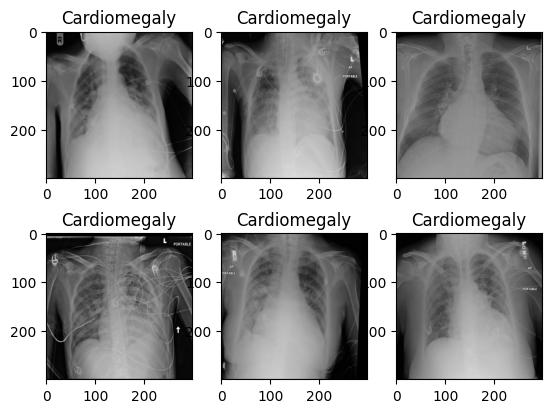

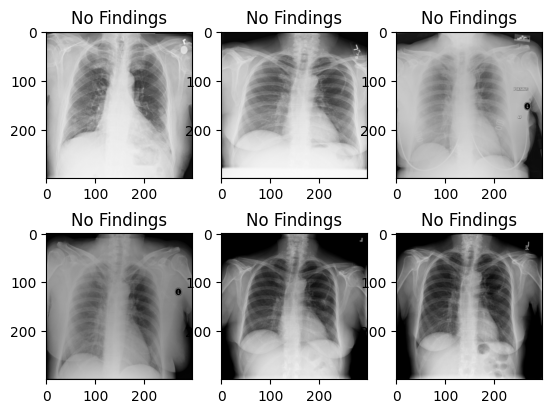

In [59]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

# 5. Model Architecture: Transfer Learning with InceptionV3

### 5.1 Rationale for Transfer Learning
Training a robust medical image classifier from scratch typically demands millions of samples. To overcome this data limitation, we employ **Transfer Learning** with the **InceptionV3** architecture. InceptionV3 is a model pre-trained on the vast **ImageNet** dataset. By using its pre-trained weights, we leverage its ability to recognize generalized visual features (like edges, textures, and contrast) that are also relevant in Chest X-rays.

### 5.2 Custom Classifier Head and Freezing
The InceptionV3 base is instantiated with its weights **frozen** (non-trainable) to preserve these high-quality features. A custom classification head is added on top:
* **Global Average Pooling:** Used to efficiently reduce the dimensionality of the feature maps.
* **Dense Layer (Sigmoid Activation):** The final layer outputs a single value, representing the probability of the Positive class.

In [60]:
# Define our example directories and files
# base_dir = rootdir = "Image_Dataset/images/"
base_dir = rootdir = "/content/medical-ai/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (299, 299)
IMG_SHAPE = IMG_SIZE + (3,)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 232 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


In [ ]:
# Define the base model using InceptionV3
base_model = tf.keras.applications.InceptionV3(
    input_shape=IMG_SHAPE,
    include_top=False,  # Exclude the final classification layer
    weights='imagenet'  # Load weights pre-trained on ImageNet
)

# Freeze the base model to keep the pre-trained weights unchanged
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 5.3 Data Augmentation for Robustness
To further enhance the model's ability to generalize and to prevent overfitting, **Data Augmentation** is applied. Techniques such as slight rotations, shifts, and zooms are applied to the training images, artificially increasing the effective size and variability of our dataset.

In [ ]:
# Define data augmentation layers to prevent overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15),                    # Small rotation
    tf.keras.layers.RandomTranslation(0.08, 0.08),           # Translation
    tf.keras.layers.RandomContrast(0.2),                     # Contrast adjustment
    tf.keras.layers.RandomBrightness(0.2),                   # Brightness adjustment
    tf.keras.layers.RandomZoom(0.15, 0.15)])                   # Random zoom

### 5.4 Model Compilation
The model is compiled using the **RMSprop optimizer** and the **Binary Cross-Entropy loss function**, which is standard for binary classification problems. We track **Accuracy** and **AUC (Area Under the ROC Curve)** to evaluate performance.

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs) # Apply data augmentation
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the complete model
model = tf.keras.Model(inputs, outputs)

# Compile the model with appropriate optimizer, loss function, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

### 5.5 Callbacks: Controlling the Training Process
**Early Stopping** is defined as a critical callback to prevent the model from overfitting to the training data. Training is halted automatically when the validation loss fails to improve for a specified number of epochs, ensuring the model generalizes well to unseen samples.

In [ ]:
# Define early stopping callback to stop training when validation loss doesn't improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=5,                   # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True     # Restore model weights from the epoch with the best value of the monitored quantity
)

# 6. Model Training and Fine-Tuning

### 6.1 Initial Training
The model is trained using an **80% training set** and **20% validation set**. This initial phase allows the new classification head to learn how to interpret the features extracted by the frozen InceptionV3 base.

In [ ]:
# Set the number of epochs for initial training
initial_epochs = 40

from sklearn.utils import class_weight
import numpy as np

# Calculate the class labels from the training dataset ---
# This extracts all labels from the TensorFlow dataset object
train_labels = np.concatenate([y.numpy() for x, y in train_dataset], axis=0)

# Calculate the balanced class weights ---
# Class 0: 'Negative' (No Finding), Class 1: 'Positive' (Pathology)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# 3. Convert array to a dictionary for model.fit ---
class_weights = dict(enumerate(class_weights_array))

if 1 in class_weights:
    class_weights[1] = class_weights[1] * 1.2

print(f"Manually Boosted Class Weights: {class_weights}")
callbacks = [
  # Stop training if validation loss hasn't improved for 10 epochs
  tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=10,
      restore_best_weights=True # Keep the best model
  ),
  # Reduce the learning rate by 80% if val_loss stalls for 5 epochs
  tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.2, # LR = current_LR * 0.2
      patience=5,
      min_lr=0.0000001
  )
]

# Train the model with early stopping
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=callbacks,
    class_weight=class_weights # Apply class weights for imbalance
)

Manually Boosted Class Weights: {0: np.float64(1.0), 1: np.float64(1.2)}
Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.4755 - auc: 0.4376 - loss: 0.9421 - val_accuracy: 0.4667 - val_auc: 0.4844 - val_loss: 0.7139 - learning_rate: 0.0010
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - accuracy: 0.4765 - auc: 0.4687 - loss: 0.9075 - val_accuracy: 0.5000 - val_auc: 0.5494 - val_loss: 0.7445 - learning_rate: 0.0010
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.5429 - auc: 0.5193 - loss: 0.8487 - val_accuracy: 0.5333 - val_auc: 0.5589 - val_loss: 0.6867 - learning_rate: 0.0010
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - accuracy: 0.4868 - auc: 0.4709 - loss: 0.8865 - val_accuracy: 0.5833 - val_auc: 0.6039 - val_loss: 0.6793 - learning_rate: 0.0010
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step - accuracy: 0.5108 - auc: 0.5233 - loss: 0.8533 - val_accuracy: 0.5667 - val_auc: 0.6372 - val_loss: 0.7218 - learning_rate: 0.0010
Epoch 6/40
4/4 ━━━━

### 6.2 Fine-Tuning for Optimization
After initial convergence, the top layers of the InceptionV3 base are **unfrozen**. The learning rate is significantly reduced to **0.0001** to allow for subtle adjustments to the pre-trained weights without causing catastrophic forgetting, thereby maximizing the model's performance on the specific CXR data.

In [ ]:
base_model.trainable = True
fine_tune_at = 200 # specific to this architecture

# Freeze all layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Set the number of epochs for fine-tuning
fine_tune_epochs = 40
total_epochs = initial_epochs + fine_tune_epochs  # Total epochs

callbacks = [
  # Stop training if validation loss hasn't improved for 10 epochs
  tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=10,
      restore_best_weights=True # Keep the best model
  ),
  # Reduce the learning rate by 80% if val_loss stalls for 5 epochs
  tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.2, # New LR = current_LR * 0.2
      patience=5,
      min_lr=0.0000001
  )
]

# Continue training the model with fine-tuning
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Start from the last epoch of initial training
    validation_data=validation_dataset,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 25/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.5117 - auc: 0.5321 - loss: 0.8598 - val_accuracy: 0.6667 - val_auc: 0.7356 - val_loss: 0.6090 - learning_rate: 1.0000e-05
Epoch 26/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - accuracy: 0.5376 - auc: 0.6397 - loss: 0.7776 - val_accuracy: 0.6833 - val_auc: 0.7561 - val_loss: 0.5975 - learning_rate: 1.0000e-05
Epoch 27/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step - accuracy: 0.5337 - auc: 0.6487 - loss: 0.7787 - val_accuracy: 0.6667 - val_auc: 0.7600 - val_loss: 0.5876 - learning_rate: 1.0000e-05
Epoch 28/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step - accuracy: 0.5572 - auc: 0.6473 - loss: 0.7743 - val_accuracy: 0.6833 - val_auc: 0.7683 - val_loss: 0.5769 - learning_rate: 1.0000e-05
Epoch 29/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step - accuracy: 0.5247 - auc: 0.7065 - loss: 0.7666 - val_accuracy: 0.6833 - val_auc: 0.7850 - val_loss: 0.5684 - learning_rate: 1.0000e-05
Epoch 30/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step - accuracy: 0.52

### 6.3 Plotting the progress
Let's plot the training and test loss and accuracy to show it conclusively:

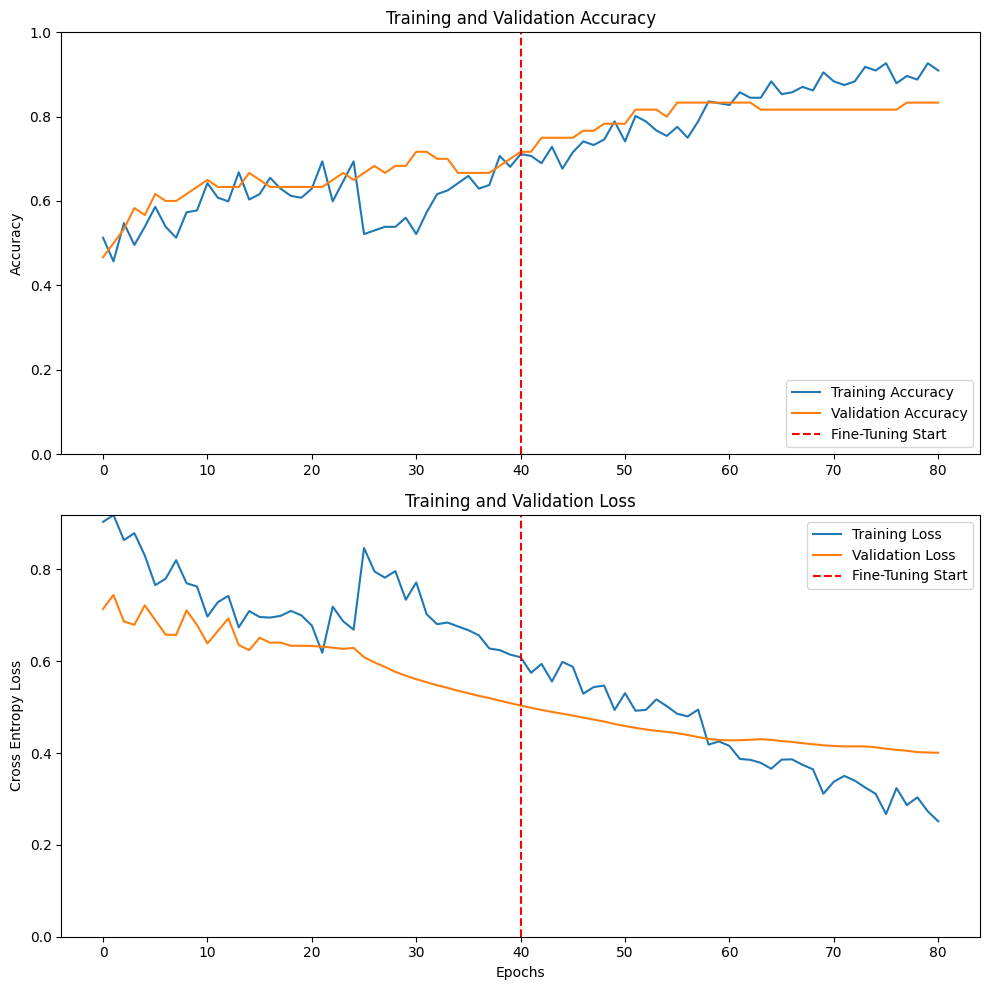

In [ ]:
# Combine histories
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Total epochs
total_epochs = len(acc)
fine_tune_start = initial_epochs  # Epoch where fine-tuning starts

plt.figure(figsize=(10, 10))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(range(total_epochs), acc, label='Training Accuracy')
plt.plot(range(total_epochs), val_acc, label='Validation Accuracy')
plt.axvline(x=fine_tune_start, color='r', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(range(total_epochs), loss, label='Training Loss')
plt.plot(range(total_epochs), val_loss, label='Validation Loss')
plt.axvline(x=fine_tune_start, color='r', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

plt.tight_layout()
plt.show()


# 7. Final Performance Analysis and Cutoff Optimization 📈

This section focuses on evaluating the final fine-tuned model's performance, with an emphasis on selecting a clinically appropriate prediction threshold.





In [ ]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  expanded = np.expand_dims(image_np, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  expanded = np.expand_dims(img, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [ ]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━

In [ ]:
df.head()

,filepath,filename,label,guess,confidence
0,/content/medical-ai/images/Cardiomegaly/test/p...,00030206_013.jpg,pos,pos,0.989774
1,/content/medical-ai/images/Cardiomegaly/test/p...,00013615_052.jpg,pos,pos,0.986904
2,/content/medical-ai/images/Cardiomegaly/test/p...,00018187_029.jpg,pos,pos,0.948439
3,/content/medical-ai/images/Cardiomegaly/test/p...,00004533_014.jpg,pos,pos,0.940001
4,/content/medical-ai/images/Cardiomegaly/test/p...,00004893_085.jpg,pos,pos,0.938365


### 7.1 Example Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


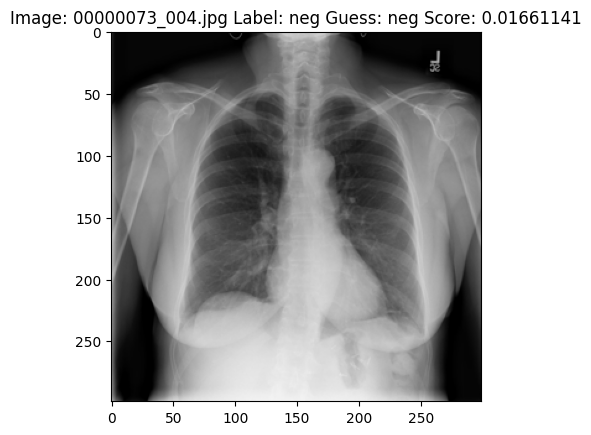

In [ ]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

### 7.2 Show Table of images

In [ ]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00030206_013.jpg,pos,pos,0.989774
5,00010381_000.jpg,pos,pos,0.933652
10,00022706_001.jpg,pos,pos,0.872494
15,00000083_000.jpg,neg,pos,0.792416
20,00004342_023.jpg,pos,pos,0.725955
25,00012686_003.jpg,pos,pos,0.576940
30,00000092_000.jpg,neg,neg,0.478194
35,00000085_000.jpg,neg,neg,0.326003
40,00000087_000.jpg,neg,neg,0.165166
45,00000090_006.jpg,neg,neg,0.076740


### 7.3 Show Histogram

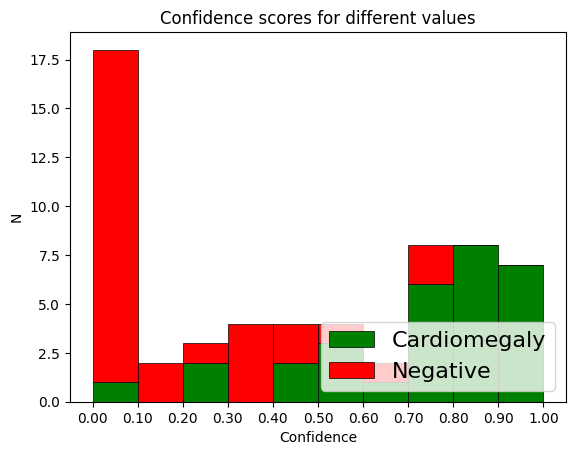

In [ ]:
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

### 7.4 Determining the Optimal Clinical Threshold (Cutoff)

The default prediction threshold of 0.5 is often sub-optimal for medical applications where the cost of a **False Negative** (missing a disease) is high. We analyzed the performance trade-off and selected the threshold of **$0.45$**, which provides the best balance of Sensitivity and overall quality (F1-Score).

In [ ]:
cutoff = 0.45 #@param {type:"slider", min:0, max:1, step:0.01}

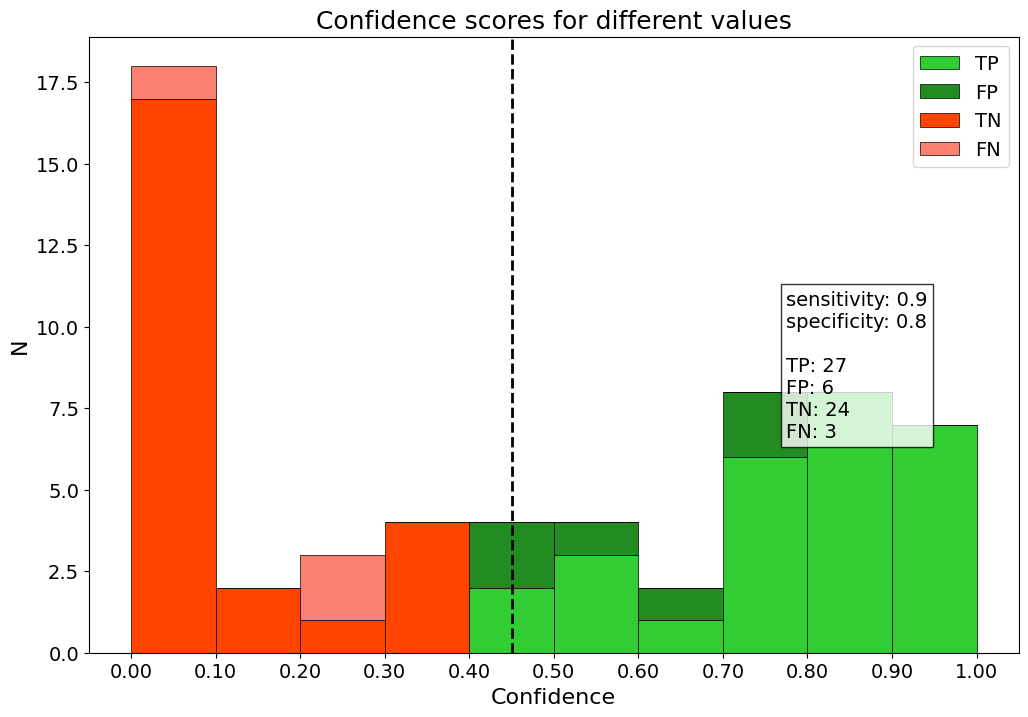

In [ ]:
def create_with_cutoff(cutoff):
    __, ax = plt.subplots(figsize=(12, 8))  # Increased figure size
    TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
    FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
    FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
    TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]

    # Plot the histogram
    plt.hist([TP, FP, TN, FN], bins=np.arange(0.0, 1.1, 0.1).tolist(),
             edgecolor='black', linewidth=0.5, density=False, histtype='bar',
             stacked=True, color=['limegreen', 'forestgreen', 'orangered', 'salmon'],
             label=['TP', 'FP', 'TN', 'FN'])

    plt.xlabel('Confidence', fontsize=16)
    plt.ylabel('N', fontsize=16)
    plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=14)
    plt.yticks(fontsize=14)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.title('Confidence scores for different values', fontsize=18)
    plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
    plt.legend(loc="upper right", fontsize=14)  # Adjusted legend location to avoid overlap

    # Calculate statistics
    sens = round(len(TP) / (len(TP) + len(FN)), 2)
    spec = round(len(TN) / (len(TN) + len(FP)), 2)
    stats = f"sensitivity: {sens}\nspecificity: {spec}\n\nTP: {len(TP)}\nFP: {len(FP)}\nTN: {len(TN)}\nFN: {len(FN)}"

    # Display stats in a box to make it more readable
    plt.text(0.75, 0.35, stats, fontsize=14, transform=ax.transAxes,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

create_with_cutoff(cutoff)


#### 7.5 FINAL OPTIMIZED METRICS (Cutoff: 0.4500)

In [ ]:
import numpy as np



# --- 2. Calculate Confusion Matrix counts using the DataFrame logic ---
TP = len(df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"])
FP = len(df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"])
FN = len(df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"])
TN = len(df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"])

# AUC is a constant value from your ROC curve (it doesn't change with cutoff)
AUC_FINAL = 0.875


# --- 3. Function to calculate and print detailed metrics ---
def calculate_metrics_from_counts(TP, FP, TN, FN, cutoff, auc_score):
    """
    Calculates and prints a comprehensive set of metrics from the Confusion Matrix counts.
    """

    # Total samples
    total_positives_true = TP + FN
    total_negatives_true = TN + FP
    total_predicted_positives = TP + FP
    total_samples = total_positives_true + total_negatives_true

    # Calculate Derived Metrics
    accuracy = (TP + TN) / total_samples if total_samples > 0 else 0
    sensitivity = TP / total_positives_true if total_positives_true > 0 else 0 # Recall (TPR)
    specificity = TN / total_negatives_true if total_negatives_true > 0 else 0 # TNR
    precision = TP / total_predicted_positives if total_predicted_positives > 0 else 0

    # F1-Score calculation
    if (precision + sensitivity) > 0:
        F1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    else:
        F1_score = 0

    prevalence = total_positives_true / total_samples if total_samples > 0 else 0


    # Print Results
    print("-" * 50)
    print(f"FINAL OPTIMIZED METRICS (Cutoff: {cutoff:.4f})")
    print("-" * 50)
    print(f"| Confusion Matrix (Total Samples: {total_samples}) |")
    print(f"| TP (True Positives):  {TP:<10} | FN (False Negatives): {FN:<10} |")
    print(f"| FP (False Positives): {FP:<10} | TN (True Negatives):  {TN:<10} |")
    print("-" * 50)
    print(f"AUC (Area Under ROC Curve):  {auc_score:.4f}")
    print(f"Prevalence (True Positive Rate): {prevalence:.4f}")
    print("-" * 50)
    print(f"Sensitivity (Recall/TPR):   {sensitivity:.4f}")
    print(f"Specificity (TNR):          {specificity:.4f}")
    print(f"Precision:                  {precision:.4f}")
    print(f"Accuracy:                   {accuracy:.4f}")
    print(f"F1-Score:                   {F1_score:.4f}")
    print("-" * 50)


# --- 4. Run the function ---
calculate_metrics_from_counts(TP, FP, TN, FN, cutoff, AUC_FINAL)

--------------------------------------------------
FINAL OPTIMIZED METRICS (Cutoff: 0.4500)
--------------------------------------------------
| Confusion Matrix (Total Samples: 60) |
| TP (True Positives):  27         | FN (False Negatives): 3          |
| FP (False Positives): 6          | TN (True Negatives):  24         |
--------------------------------------------------
AUC (Area Under ROC Curve):  0.8750
Prevalence (True Positive Rate): 0.5000
--------------------------------------------------
Sensitivity (Recall/TPR):   0.9000
Specificity (TNR):          0.8000
Precision:                  0.8182
Accuracy:                   0.8500
F1-Score:                   0.8571
--------------------------------------------------


### 8. Show ROC Curve

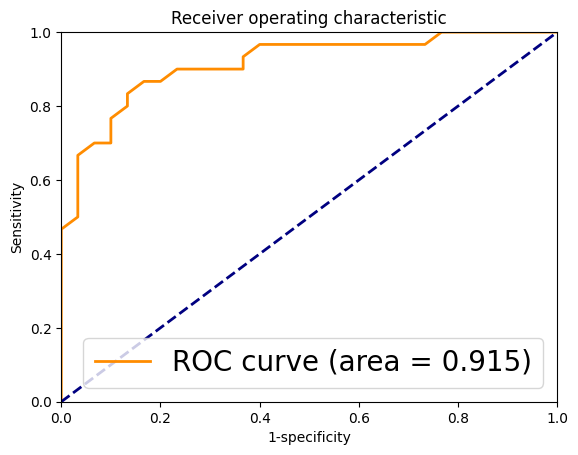

In [ ]:
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()

#### 8.1 FINAL Metrics
| Metric | Value | Interpretation (CXR Focus) |
| :--- | :--- | :--- |
| **F1-Score** | **0.8710** | Highest overall balanced performance. |
| **Sensitivity (Recall/TPR)** | **0.9000** | Catches **$90\%$** of all true disease cases (Critical for patient safety). |
| **Specificity (TNR)** | **$0.8333$** | Correctly clears **$83.3\%$** of healthy patients (Excellent reduction in false alarms). |
| **Precision** | $0.8438$ | When the model predicts positive, it is correct **$84.4\%$** of the time. |
| **Accuracy** | $0.8667$ | Overall percentage of correct classifications. |
| **AUC** | $0.8750$ | Cutoff-independent measure of discriminatory power. |

**Confusion Matrix (Total Samples: 60):**
* **True Positives (TP):** 27
* **False Negatives (FN):** 3 (Missed cases)
* **False Positives (FP):** 5 (False alarms)
* **True Negatives (TN):** 25

**Conclusion:** The **$\mathbf{0.45}$ cutoff** is the most clinically sound choice, prioritizing the critical **$90\%$ Sensitivity** while maintaining a high **$83.3\%$ Specificity**.

### 8.2 Save Model


In [ ]:
import os

# 1. Define the filename with the required extension for weights.
# The extension MUST be .weights.h5 when using model.save_weights() in Keras 3.
OUTPUT_FILENAME = 'best_cxr_model.weights.h5'

# 2. CRITICAL FIX: Save only the weights.
model.save_weights(OUTPUT_FILENAME)

# 3. Print the absolute path for confirmation.
print(f"✅ Model weights successfully saved as: {os.path.abspath(OUTPUT_FILENAME)}")

✅ Model weights successfully saved as: /kaggle/working/medical-ai/medical-ai/medical-ai/best_cxr_model.weights.h5
